In [1]:
import pandas as pd

In [2]:
# Import LA19 Feedback
data = pd.read_csv('responses.csv')

In [3]:
# Rename columns from 

cols = ['id', 'overall_rating', 'overall_oe', 'likelyToAttend_rating', 'likelyToAttend_oe', 'refer_rating', 
        'relationships_rating', 'relationships_oe', 'programming_rating', 'talks_rating',
        'talks_oe', 'music_rating', 'music_oe', 'culinary_rating', 'culinary_oe', 'wellness_rating', 'wellness_oe', 
        'campusExperience_oe', 'hotel_rating', 'hotel_oe', 'hotel', 'highlight_oe', 'improve_oe', 'email', 
        'start_date', 'submit_date', 'network_id'
       ]

data.columns = cols

In [4]:
# Iterable for open-ended columns
open_ends = ['overall_oe', 'likelyToAttend_oe', 'relationships_oe', 'talks_oe', 'music_oe', 'culinary_oe', 
             'wellness_oe', 'hotel_oe', 'campusExperience_oe', 'highlight_oe', 'improve_oe']

### Named Entity Recognition

In [6]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [7]:
# Establish Connection with Watson NLU

authenticator = IAMAuthenticator('FS1cv-0TP6xeBG8IjITSNkGy1gSKw58BQ-2jgT-F7xPT')

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator = authenticator
)

natural_language_understanding.set_service_url('https://gateway.watsonplatform.net/natural-language-understanding/api')

In [8]:
# Function for extracting entities 

def get_entities(oe_column):

    entities = []
    for article_text in oe_column:
        if str(article_text) != "":
            try:
                response = natural_language_understanding.analyze(
                    text = article_text, 
                    features=Features(entities=EntitiesOptions(sentiment=True))).get_result()
            except:
                response = {'entities' : "None"}

            person_ents = []
            for item in response['entities']:
                try:
                    type = item['type']
                    text = item['text']
                    label = item['sentiment']['score']

                    dictionary = {'type' : type,
                                  'text' : text,
                                  'label' : label}
                    person_ents.append(dictionary)

                except:
                    person_ents.append('None')
        else:
            person_ents.append('NA')
            
        entities.append(person_ents)      
        
    return entities

In [ ]:
# Extract entities for all open-ended columns
for column in open_ends:
    colname = str(column) + '_entities'
    data[colname] = get_entities(data[column])
    
    print(colname)

### Text Summarization

In [5]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

class TextSummary(object):

    def __init__(self, feeds_str, num_sents):
        self.summary = str()
        
        parser = PlaintextParser.from_string(feeds_str, Tokenizer("english"))
        summarizer = LexRankSummarizer()

        sentences = summarizer(parser.document, num_sents)  
        for sentence in sentences:
            self.summary += (sentence.__unicode__())

    def output(self):
        return self.summary

In [13]:
for column in open_ends:
    colname = str(column) + '_textSum'
    
    textSummary = []
    for item in data[column]:
        summary = TextSummary(item, 1)
        textSummary.append(summary.output())
    
    data[colname] = textSummary

### Text Rank

In [15]:
import nltk

In [16]:
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string
    
    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent)) for tagged_sent in tagged_sents))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda word__pos__chunk: word__pos__chunk[2] != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

In [17]:
def extract_candidate_words(text, good_tags=set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates

In [18]:
def score_keyphrases_by_tfidf(texts, candidates='chunks'):
    import gensim, nltk
    
    # extract candidates from each text in texts, either chunks or words
    if candidates == 'chunks':
        boc_texts = [extract_candidate_chunks(text) for text in texts]
    elif candidates == 'words':
        boc_texts = [extract_candidate_words(text) for text in texts]
    # make gensim dictionary and corpus
    dictionary = gensim.corpora.Dictionary(boc_texts)
    corpus = [dictionary.doc2bow(boc_text) for boc_text in boc_texts]
    # transform corpus with tf*idf model
    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    return corpus_tfidf, dictionary

In [19]:
def score_keyphrases_by_textrank(text, n_keywords=0.2):
    from itertools import takewhile, tee
    import operator
    import networkx, nltk
    
    # tokenize for all words, and extract *candidate* words
    words = [word.lower()
             for sent in nltk.sent_tokenize(text)
             for word in nltk.word_tokenize(sent)]
    candidates = extract_candidate_words(text)
    # build graph, each node is a unique candidate
    graph = networkx.Graph()
    graph.add_nodes_from(set(candidates))
    # iterate over word-pairs, add unweighted edges into graph
    def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)
    for w1, w2 in pairwise(candidates):
        if w2:
            graph.add_edge(*sorted([w1, w2]))
    # score nodes using default pagerank algorithm, sort by score, keep top n_keywords
    ranks = networkx.pagerank(graph)
    if 0 < n_keywords < 1:
        n_keywords = int(round(len(candidates) * n_keywords))
    word_ranks = {word_rank[0]: word_rank[1]
                  for word_rank in sorted(ranks.items(), key=operator.itemgetter(1), reverse=True)[:n_keywords]}
                  #for word_rank in sorted(ranks.iteritems(), key=lambda x: x[1], reverse=True)[:n_keywords]}
                  
    #sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[:3]
    keywords = set(word_ranks.keys())
    # merge keywords into keyphrases
    keyphrases = {}
    j = 0
    for i, word in enumerate(words):
        if i < j:
            continue
        if word in keywords:
            kp_words = list(takewhile(lambda x: x in keywords, words[i:i+10]))
            avg_pagerank = sum(word_ranks[w] for w in kp_words) / float(len(kp_words))
            keyphrases[' '.join(kp_words)] = avg_pagerank
            # counter as hackish way to ensure merged keyphrases are non-overlapping
            j = i + len(kp_words)
            
    return sorted(keyphrases.items(), key=operator.itemgetter(1), reverse=True)
    #return sorted(keyphrases.iteritems(), key=lambda x: x[1], reverse=True)

In [20]:
# 

for column in open_ends:
    colname = str(column) + '_textRank'
    
    textRank = []
    for oe in data[column]:
        textRank.append(score_keyphrases_by_textrank(str(oe), .2))
        
    data[colname] = textRank

### Topic Modeling

In [6]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 

def text_cleanup(input_text):
    text = str(input_text)
    one = " ".join([i for i in text.lower().split() if i not in stopwords])
    two = "".join(re.sub(r'[^a-zA-Z ]', '', i) for i in one if i not in punctuation)
    three = [WordNetLemmatizer().lemmatize(i) for i in two.split()]
    return three

In [7]:
import re
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim
import os

In [8]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes = 50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Define function to print dominant topic, percent contribution, keywords and text

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#### Highlight 

In [11]:
column = 'highlight_oe'

text = data[[column]].applymap(text_cleanup)[column]
dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpora = [dictionary.doc2bow(doc) for doc in text]

In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpora, texts=text, start=5, limit=30, step=3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3270: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  left, right = sorted([left, right], reverse=reverse)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3652: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  bottom, top = sorted([bottom, top], reverse=reverse)


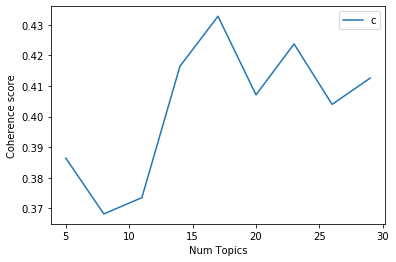

In [13]:
### Show graph
limit=30; start=5; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [14]:
lda_model = ldamodel.LdaModel(corpora, num_topics=20, id2word = dictionary, passes=50)

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.274874 -0.006176       1        1  9.967472
13    -0.063805  0.051349       2        1  8.864891
6      0.130780  0.405409       3        1  8.233261
5     -0.304277  0.108292       4        1  7.345948
18     0.059925 -0.111668       5        1  5.955516
16     0.075996  0.018418       6        1  5.924655
9      0.088214 -0.014731       7        1  5.241302
17     0.073734 -0.042563       8        1  5.045845
10     0.093443 -0.029989       9        1  4.859543
19    -0.007374 -0.099579      10        1  4.573889
15     0.134052 -0.044334      11        1  4.510353
12    -0.016626 -0.047682      12        1  4.427832
0     -0.030459 -0.046502      13        1  4.235630
7      0.004291 -0.036705      14        1  3.916566
4      0.051430 -0.059147      15        1  3.768443
1      0.013642 -0.047386      16        1  2.783772
3      0.044209 -0.014939      17        1  2.760936
2      0.046535  0.034520      18        1  2.698970
14    -0.029407 -0.025686      19        1  2.670842
11    -0.089429  0.009099      20        1  2.214340, topic_info=    Category        Freq        Term       Total  loglift  logprob
7    Default   77.000000  connection   77.000000  30.0000  30.0000
65   Default   57.000000       human   57.000000  29.0000  29.0000
0    Default   66.000000     meeting   66.000000  28.0000  28.0000
2    Default  119.000000      people  119.000000  27.0000  27.0000
8    Default   58.000000      friend   58.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
111  Topic20    0.043137  absolutely    2.518708  -0.2569  -7.2580
251  Topic20    0.043137      change    2.518725  -0.2569  -7.2580
2    Topic20    0.983074      people  119.891998  -0.9934  -4.1317
18   Topic20    0.043372  breathwork   14.019140  -1.9681  -7.2525
7    Topic20    0.043203  connection   77.735962  -3.6850  -7.2564

[888 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
314       7  0.387621        able
314      15  0.387621        able
111       4  0.397029  absolutely
111      15  0.397029  absolutely
417      14  0.384143      access
...     ...       ...         ...
313       7  0.117703        yoga
313      10  0.117703        yoga
313      18  0.117703        yoga
47        2  0.548510         you
47        6  0.365673         you

[1187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 14, 7, 6, 19, 17, 10, 18, 11, 20, 16, 13, 1, 8, 5, 2, 4, 3, 15, 12])

In [16]:
output = format_topics_sentences(lda_model, corpora, text)

In [17]:
category = 'Highlights'


dom_topic = f'{category}_Dominant_Topic'
perc_contribution = f'{category}_Perc_Contribution'
topic_keywords = f'{category}_Topic_Keywords'

output.columns = [dom_topic, perc_contribution, topic_keywords]

In [18]:
data = pd.concat([data, output], axis = 1)

#### Campus Experience

In [19]:
column = 'campusExperience_oe'

text = data[[column]].applymap(text_cleanup)[column]
dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpora = [dictionary.doc2bow(doc) for doc in text]

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpora, texts=text, start=5, limit=30, step=3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3270: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  left, right = sorted([left, right], reverse=reverse)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3652: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  bottom, top = sorted([bottom, top], reverse=reverse)


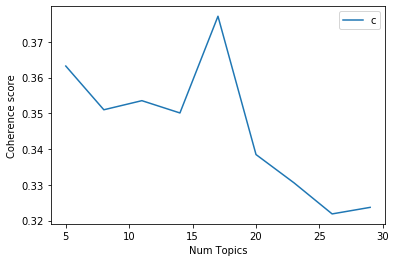

In [21]:
### Show graph
limit=30; start=5; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
lda_model = ldamodel.LdaModel(corpora, num_topics=17, id2word = dictionary, passes=50)

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.014115  0.001758       1        1  11.115880
10     0.156713  0.128111       2        1   7.840755
4     -0.055702  0.093029       3        1   7.563483
0     -0.010635 -0.089572       4        1   7.536129
5      0.060865 -0.059150       5        1   7.008517
2      0.024573 -0.045127       6        1   6.988655
7      0.008696  0.010791       7        1   6.981698
9     -0.216039 -0.026620       8        1   6.657063
3     -0.033146  0.041175       9        1   6.250366
14    -0.060024 -0.078766      10        1   5.835683
11    -0.025467  0.120516      11        1   5.111350
13     0.156427 -0.088487      12        1   4.915061
8      0.001823 -0.146746      13        1   3.776154
12     0.058689 -0.011805      14        1   3.749394
6     -0.056443  0.040450      15        1   3.432229
15    -0.028545  0.020496      16        1   3.262213
1      0.004100  0.089947      17        1   1.975370, topic_info=    Category       Freq      Term      Total  loglift  logprob
187  Default  29.000000       nan  29.000000  30.0000  30.0000
43   Default  24.000000  navigate  24.000000  29.0000  29.0000
9    Default  40.000000      good  40.000000  28.0000  28.0000
38   Default  49.000000      easy  49.000000  27.0000  27.0000
32   Default  84.000000     great  84.000000  26.0000  26.0000
..       ...        ...       ...        ...      ...      ...
86   Topic17   0.884860     night  21.787918   0.7207  -4.5276
118  Topic17   0.884854      many  13.260637   1.2173  -4.5276
26   Topic17   0.884853     space  64.254684  -0.3608  -4.5276
10   Topic17   0.884853     hotel  18.199841   0.9007  -4.5276
91   Topic17   0.884853      also  17.011652   0.9682  -4.5276

[940 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
90        1  0.160236  able
90        3  0.080118  able
90        6  0.240354  able
90        7  0.080118  able
90        8  0.160236  able
...     ...       ...   ...
82        4  0.188287   yet
82        7  0.376574   yet
532       8  0.760540  yoga
268       6  0.281617  zone
268      10  0.563235  zone

[1828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 11, 5, 1, 6, 3, 8, 10, 4, 15, 12, 14, 9, 13, 7, 16, 2])

In [24]:
output = format_topics_sentences(lda_model, corpora, text)

category = 'campusExperience'


dom_topic = f'{category}_Dominant_Topic'
perc_contribution = f'{category}_Perc_Contribution'
topic_keywords = f'{category}_Topic_Keywords'

output.columns = [dom_topic, perc_contribution, topic_keywords]

data = pd.concat([data, output], axis = 1)

#### Improve

In [29]:
column = 'improve_oe'

text = data[[column]].applymap(text_cleanup)[column]
dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpora = [dictionary.doc2bow(doc) for doc in text]

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpora, texts=text, start=5, limit=30, step=3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3270: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  left, right = sorted([left, right], reverse=reverse)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:3652: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  bottom, top = sorted([bottom, top], reverse=reverse)


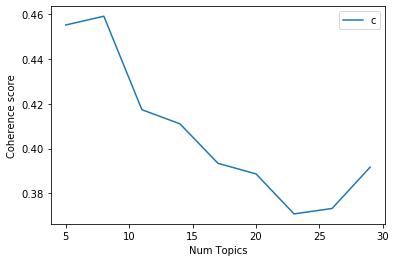

In [31]:
### Show graph
limit=30; start=5; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
lda_model = ldamodel.LdaModel(corpora, num_topics=8, id2word = dictionary, passes=50)

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008169 -0.032422       1        1  29.076040
7     -0.010773 -0.031503       2        1  22.793570
0      0.041199 -0.126152       3        1  13.287626
2      0.098195 -0.016889       4        1  12.237965
3     -0.085334  0.018846       5        1   7.898960
4      0.070787  0.089721       6        1   5.547050
6     -0.131572 -0.007951       7        1   5.072198
5      0.009329  0.106349       8        1   4.086595, topic_info=    Category        Freq         Term       Total  loglift  logprob
173  Default   73.000000          nan   73.000000  30.0000  30.0000
52   Default  105.000000       summit  105.000000  29.0000  29.0000
71   Default   65.000000       dinner   65.000000  28.0000  28.0000
36   Default   65.000000   experience   65.000000  27.0000  27.0000
57   Default   58.000000          app   58.000000  26.0000  26.0000
..       ...         ...          ...         ...      ...      ...
635   Topic8    2.139022        there   16.291224   1.1672  -5.2933
57    Topic8    2.597364          app   58.053192   0.0906  -5.0991
87    Topic8    2.347603  programming   31.771191   0.5923  -5.2002
159   Topic8    2.418219         like   98.867577  -0.5133  -5.1706
35    Topic8    2.347476        event  130.918411  -0.8238  -5.2003

[574 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
863       1  0.723807    able
863       2  0.090476    able
863       3  0.090476    able
278       1  0.135812  access
278       2  0.203718  access
...     ...       ...     ...
157       8  0.049264    year
816       2  0.470064    yoga
816       3  0.376052    yoga
816       7  0.094013    yoga
839       4  0.856709    zone

[1267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 3, 4, 5, 7, 6])

In [34]:
output = format_topics_sentences(lda_model, corpora, text)

category = 'improve'


dom_topic = f'{category}_Dominant_Topic'
perc_contribution = f'{category}_Perc_Contribution'
topic_keywords = f'{category}_Topic_Keywords'

output.columns = [dom_topic, perc_contribution, topic_keywords]

data = pd.concat([data, output], axis = 1)